**Regresión Logística - Cancer de Mama**

In [ ]:
# Import Other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    r2_score
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import joblib

In [ ]:
# Load dataset
dataset = load_breast_cancer()
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = dataset.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
)

print(f"Original features: {X_train.shape[1]}")
print(f"Train set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Original features: 30
Train set size: 455 samples
Test set size: 114 samples


In [ ]:
# # Feature scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Model training
# model = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=1000, random_state=42)
# model.fit(X_train_scaled, y_train)

# # Model evaluation
# y_pred = model.predict(X_test_scaled)
# y_prob = model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Create pipeline with feature selection and scaling
pipeline = Pipeline([
    ('feature_selector', SelectKBest(score_func=f_classif)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=5000))
])

# Hyperparameter grid for tuning
param_grid = {
    'feature_selector__k': [10, 15, 20, 'all'],  # Feature selection
    'classifier__C': np.logspace(-4, 4, 20),      # Regularization strength
    'classifier__penalty': ['l1', 'l2'],          # Regularization type
    'classifier__solver': ['liblinear'],          # Solver that handles both penalties
    'classifier__class_weight': [None, 'balanced']  # Handle class imbalance
}

# Setup GridSearchCV with stratified k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Optimize for AUC
    n_jobs=-1,
    verbose=1
)

In [ ]:
print("\nStarting hyperparameter tuning...")
grid_search.fit(X_train, y_train)

# Get best model
model = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV AUC: {grid_search.best_score_:.4f}")

# Get selected features if feature selection was used
if 'feature_selector' in model.named_steps:
    selector = model.named_steps['feature_selector']
    selected_features = X_train.columns[selector.get_support()]
    print(f"\nSelected {len(selected_features)} features:")
    print(selected_features.tolist())

# Model evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class


Starting hyperparameter tuning...
Fitting 5 folds for each of 320 candidates, totalling 1600 fits

Best parameters: {'classifier__C': np.float64(0.615848211066026), 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'feature_selector__k': 'all'}
Best CV AUC: 0.9955

Selected 30 features:
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Confusion Matrix:
[[41  2]
 [ 1 70]]


In [ ]:
# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Recall (Sensitivity)": recall_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Specificity": recall_score(y_test, y_pred, pos_label=0),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC AUC Score": roc_auc_score(y_test, y_pred),
    "R2 Score": r2_score(y_test, y_pred)
}

print("\nOptimized Model Metrics:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")



Optimized Model Metrics:
Accuracy: 0.9737
Recall (Sensitivity): 0.9859
Precision: 0.9722
Specificity: 0.9535
F1 Score: 0.9790
ROC AUC Score: 0.9697
R2 Score: 0.8880


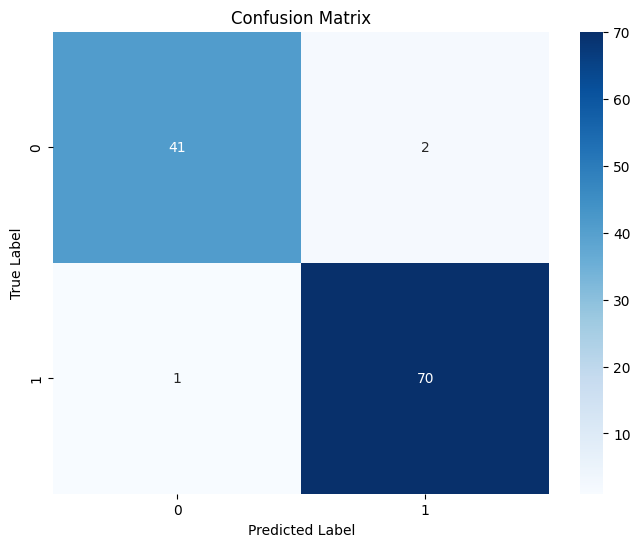

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

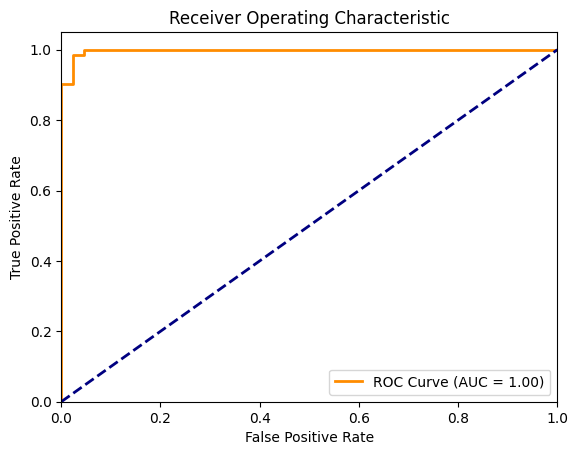

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Feature Importance
importances = model.named_steps['classifier'].coef_[0]
feature_importances = pd.DataFrame({
    'Variable': dataset.feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importances.head(10))


Top 10 Important Features:
                   Variable  Importance
15        compactness error    0.630579
19  fractal dimension error    0.500660
18           symmetry error    0.389337
5          mean compactness    0.381333
8             mean symmetry    0.148516
11            texture error    0.139539
16          concavity error    0.122186
9    mean fractal dimension    0.122009
25        worst compactness   -0.029307
4           mean smoothness   -0.084966


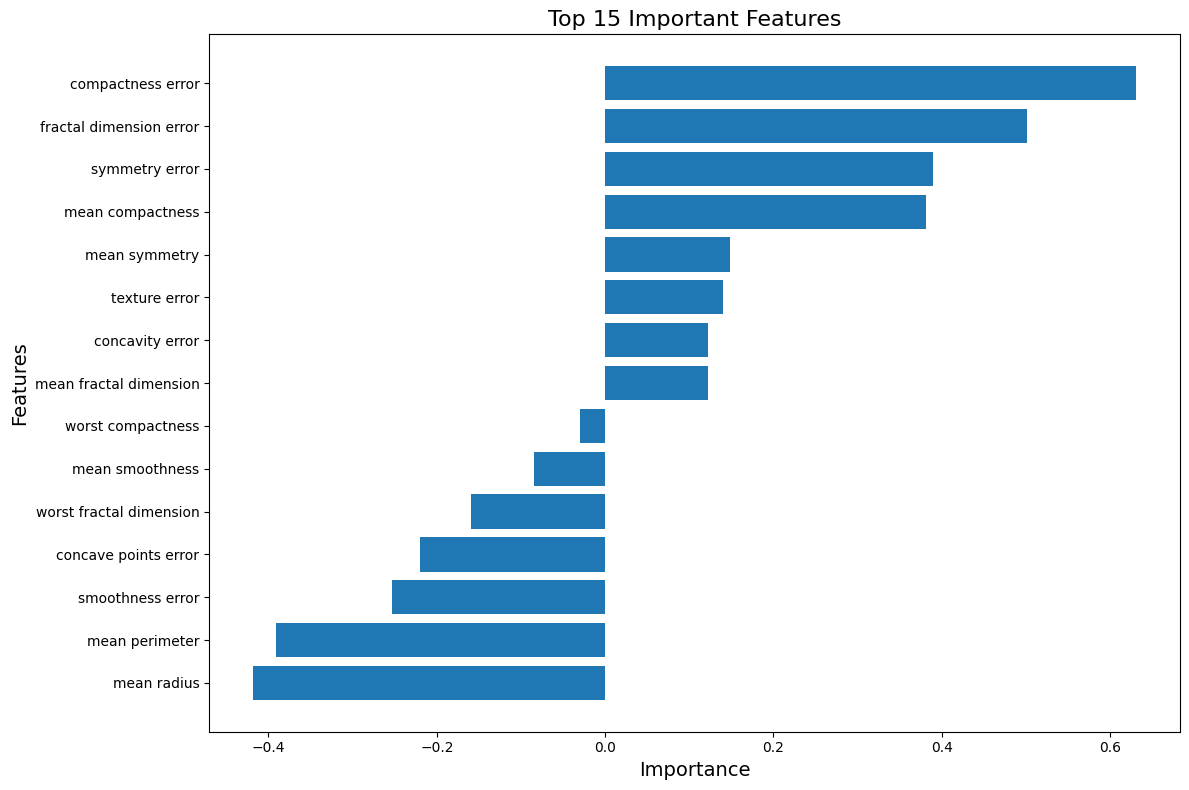

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Variable'][:15], feature_importances['Importance'][:15])
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 15 Important Features', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300)
plt.show()

In [ ]:
# Save model
joblib.dump(model, 'breast_cancer_model.pkl')
print("\nModel saved as 'breast_cancer_model.pkl'")


Model saved as 'breast_cancer_model.pkl'


In [ ]:
# Load saved model
loaded_model = joblib.load('breast_cancer_model.pkl')

# making predictions with loaded model
y_pred = model.predict(X_test)

In [ ]:
# Validate loaded model
y_pred_loaded = loaded_model.predict(X_test)
acc_loaded = accuracy_score(y_test, y_pred_loaded)
print(f"Loaded model accuracy: {acc_loaded:.4f} (original: {metrics['Accuracy']:.4f})")

Loaded model accuracy: 0.9737 (original: 0.9737)
